In [1]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [28]:
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

## 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [3]:
# 구글 계정 액세스
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

path = "/content/drive/MyDrive/Colab/all"
image_list = os.listdir(path)
image_list_png = [image for image in image_list if image.endswith(".png")]

print('image_list_png :{}'.format(image_list_png))

image_list_png :[]


In [5]:
import PIL
import glob

imgs = glob.glob('/content/drive/MyDrive/Colab/all/*.png')

for img in imgs:
    try:
        img = PIL.Image.open(img)
    except PIL.UnidentifiedImageError:
        print(img)

In [6]:
# 훈련 검증, 테스트 폴더로 이미지 복사 
import os, shutil
original_dataset_dir = '/content/drive/MyDrive/Colab/all/'

folder_list = []
for path_ in os.listdir(original_dataset_dir):
    if path_.startswith('.'):
        pass
    else:
        path2 = original_dataset_dir + path_
        folder_list.append(path_)
        
print(folder_list)

plant_cnt = {}
for path in folder_list:
    plant_cnt[path] = len(os.listdir(original_dataset_dir+path))
    
print(plant_cnt)

['stuckyi', 'monstera']
{'stuckyi': 122, 'monstera': 288}


In [9]:
# datasets 파일 만들기
base_dir = './datasets/' 
os.mkdir(base_dir)
# datasets 파일 안에 Plant 파일 만들기
base_dir = './datasets/Plant' # 소규모 데이터셋 저장할 디렉토리
os.mkdir(base_dir)

In [10]:
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

os.mkdir(train_dir)
os.mkdir(valid_dir)
os.mkdir(test_dir)

In [ ]:
# 이미지 데이터 이름 변경 (순서매기기)
for path in folder_list:
    i = 1
    for imgPath in os.listdir(original_dataset_dir+path):
        src = os.path.join(original_dataset_dir+path, imgPath)
        dst_ = path + '_' + str(i) + '.png'
        dst = os.path.join(original_dataset_dir+path, dst_)
        
        print(src)
        print(dst)
        print('-' * 40)
        
        os.rename(src, dst)
        i += 1

In [ ]:
data_list = [train_dir, valid_dir, test_dir]

for dataset in data_list:
    print('dataset : ',dataset)
    for plant in plant_cnt:
        filePath_ = os.path.join(dataset, plant)
        os.mkdir(filePath_)

        # 데이터 개수의 반틈 train 폴더에 복사
        if dataset == data_list[0]:
            cnt = int(int(plant_cnt[plant])/2)
            fnames = ['{}_{}.png'.format(plant, i+1) for i in range(0,cnt)]
            print(cnt)
            print(plant,'- train_dir len :', len(fnames))
        
        elif dataset == data_list[1]:
            cnt = int(int(plant_cnt[plant])/2)
            cnt3 = int((int(plant_cnt[plant])/4)*3)
            fnames = ['{}_{}.png'.format(plant, i+1) for i in range(cnt,cnt3)]
            print(plant,'- valid_dir len :', len(fnames))
#         print("fnames : ",fnames)
        else :
            cnt3 = int((int(plant_cnt[plant])/4)*3)
            fnames = ['{}_{}.png'.format(plant, i+1) for i in range(cnt3,plant_cnt[plant])]
            print(plant, '-test_dir len :', len(fnames))
            
        for fname in fnames:
            src = os.path.join(original_dataset_dir,plant)
            src2 = os.path.join(src,fname)
            dst = os.path.join(filePath_,fname)
#             print(src2)
            print('dst :',dst)
            shutil.copyfile(src2,dst)

In [13]:
# 안열리는 파일 삭제 
import PIL, glob
from PIL import Image
from os import remove

datalist = ['train', 'test', 'valid']

for data in datalist : 
    imgs_ = glob.glob(f"./datasets/Plant/{data}/*/*.png")

    for img in imgs_:
        try:
            img = PIL.Image.open(img)
        except PIL.UnidentifiedImageError:
            print(img)
            remove(img)

In [14]:
for plant in plant_cnt:
    path_train = os.path.join('/content/datasets/Plant/train',plant)
    print(plant)
    print('훈련용 이미지 개수 : ', len(os.listdir(path_train)))

    path_valid = os.path.join('/content/datasets/Plant/valid',plant)
    print('valid 이미지 개수 : ', len(os.listdir(path_valid)))

    path_test = os.path.join('/content/datasets/Plant/test',plant)
    print('test 이미지 개수 : ', len(os.listdir(path_test)))
    print('-' * 40)    

stuckyi
훈련용 이미지 개수 :  61
valid 이미지 개수 :  30
test 이미지 개수 :  31
----------------------------------------
monstera
훈련용 이미지 개수 :  144
valid 이미지 개수 :  72
test 이미지 개수 :  72
----------------------------------------


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [17]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_vaild = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/datasets/Plant'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
valid_datasets = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms_vaild)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=2, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=2, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=2, shuffle=True, num_workers=2)

print('학습 데이터셋 크기:', len(train_datasets))
print('검증 데이터셋 크기:', len(valid_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 205
검증 데이터셋 크기: 102
테스트 데이터셋 크기: 103
클래스: ['monstera', 'stuckyi']


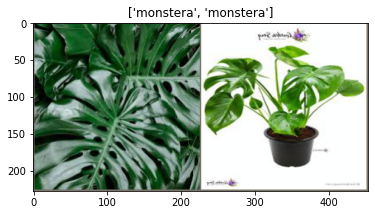

In [18]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [21]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [22]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.7357 Acc: 74.1463% Time: 152.1147s
#1 Loss: 0.6675 Acc: 80.0000% Time: 297.2175s
#2 Loss: 0.4943 Acc: 84.8781% Time: 447.8067s
#3 Loss: 0.4771 Acc: 85.3659% Time: 595.0787s
#4 Loss: 0.2407 Acc: 93.1707% Time: 745.2995s
#5 Loss: 0.2910 Acc: 92.1951% Time: 894.9107s
#6 Loss: 0.2117 Acc: 94.1463% Time: 1044.9874s
#7 Loss: 0.0859 Acc: 96.5854% Time: 1195.3629s
#8 Loss: 0.1415 Acc: 95.1219% Time: 1345.2573s
#9 Loss: 0.0186 Acc: 99.5122% Time: 1492.6734s
#10 Loss: 0.0123 Acc: 99.5122% Time: 1641.3133s
#11 Loss: 0.0083 Acc: 100.0000% Time: 1788.8306s
#12 Loss: 0.0114 Acc: 100.0000% Time: 1937.7275s
#13 Loss: 0.0080 Acc: 100.0000% Time: 2085.0314s
#14 Loss: 0.0040 Acc: 100.0000% Time: 2233.9467s
#15 Loss: 0.0042 Acc: 100.0000% Time: 2381.1416s
#16 Loss: 0.0037 Acc: 100.0000% Time: 2532.2381s
#17 Loss: 0.0037 Acc: 100.0000% Time: 2681.3179s
#18 Loss: 0.0019 Acc: 100.0000% Time: 2830.9225s
#19 Loss: 0.0016 Acc: 100.0000% Time: 2978.8619s
#20 Loss: 0.0019 Acc: 100.0000% Time: 3128.0525

In [29]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

Output hidden; open in https://colab.research.google.com to view.

In [40]:
# 모델 저장
save = torch.save(model.state_dict(), "resnet.pt")

In [42]:
## 성능이 가장 좋은 모델 저장
# import copy
# best_model_state = copy.deepcopy(model.state_dict())

In [47]:
# 모델 불러오기
model = torch.load('resnet.pt')
model

OrderedDict([('conv1.weight',
              tensor([[[[ 4.3479e-05,  7.0745e-03, -2.2164e-02,  ..., -4.8866e-02,
                         -5.2748e-02, -8.1267e-02],
                        [-2.4706e-03,  8.4695e-03,  1.8703e-02,  ...,  6.5037e-03,
                         -1.8051e-02, -3.5413e-02],
                        [ 1.4591e-02,  2.6306e-02,  1.8949e-02,  ...,  1.0713e-01,
                          6.5609e-02,  5.5363e-02],
                        ...,
                        [-1.0596e-02,  2.9720e-02, -7.2598e-03,  ..., -1.2243e-01,
                         -7.3284e-02,  1.0538e-02],
                        [-6.3421e-03,  5.0420e-02,  6.5286e-02,  ...,  2.8940e-02,
                         -3.0406e-02, -1.3687e-02],
                        [-8.9891e-02, -3.0295e-02, -1.6961e-02,  ...,  3.9383e-02,
                          2.6429e-02,  4.2302e-03]],
              
                       [[-3.2196e-02,  3.4248e-03,  1.6301e-02,  ...,  4.4577e-02,
                          3.3300